<a href="https://colab.research.google.com/github/Pandu98-pkh/DeepLearning/blob/main/06.%20Week%206/Notebook%20Assigment/LSTM%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Models for Sarcasm Detection

This notebook implements LSTM models using both PyTorch and TensorFlow to detect sarcasm in news headlines using the DeteksiSarkasme.json dataset.

## Requirements:
1. Build deep learning models (PyTorch and TensorFlow)
2. Use evaluation metrics (Accuracy, Precision, Recall, F1-Score, AUC, ROC)
3. Visualize accuracy matrix and loss
4. Hyperparameter tuning with Keras Tuner (TensorFlow)
5. Achieve minimum 80% accuracy on training and testing sets

## Dataset
The dataset contains news headlines with binary labels:
- 0: Not sarcastic
- 1: Sarcastic

In [25]:
!pip install keras-tuner==1.4.6

In [26]:
# Import necessary libraries
import json
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# TensorFlow libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Keras Tuner for hyperparameter tuning
import keras_tuner as kt

# NLTK for text preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Loading and Exploration

In [27]:
import requests

data_path = 'https://raw.githubusercontent.com/Pandu98-pkh/DeepLearning/refs/heads/main/06.%20Week%206/Dataset/DeteksiSarkasme.json'

# Fetch the content from the URL
response = requests.get(data_path)
response.raise_for_status() # Raise an exception for bad status codes (e.g., 404)

data = []
for line in response.text.splitlines():
    data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

# Basic statistics
print(f"\nDataset Info:")
print(f"Total samples: {len(df)}")
print(f"Sarcastic samples: {df['is_sarcastic'].sum()}")
print(f"Non-sarcastic samples: {len(df) - df['is_sarcastic'].sum()}")
print(f"Sarcasm ratio: {df['is_sarcastic'].mean():.2%}")

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

Dataset shape: (26709, 3)
Columns: ['article_link', 'headline', 'is_sarcastic']

First few rows:
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  

Dataset Info:
Total samples: 26709
Sarcastic samples: 11724
Non-sarcastic samples: 14985
Sarcasm ratio: 43.90%

Missing values:
article_link    0
headl

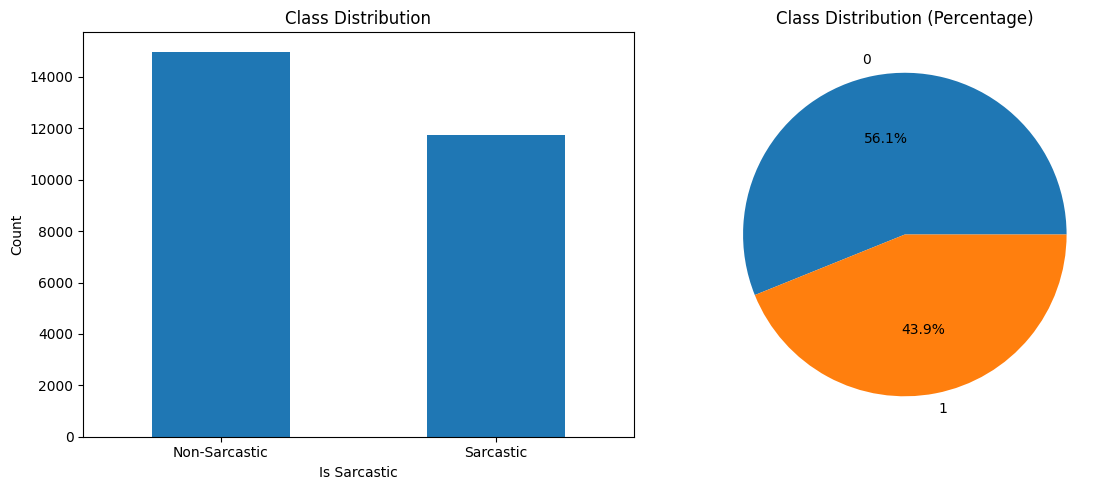

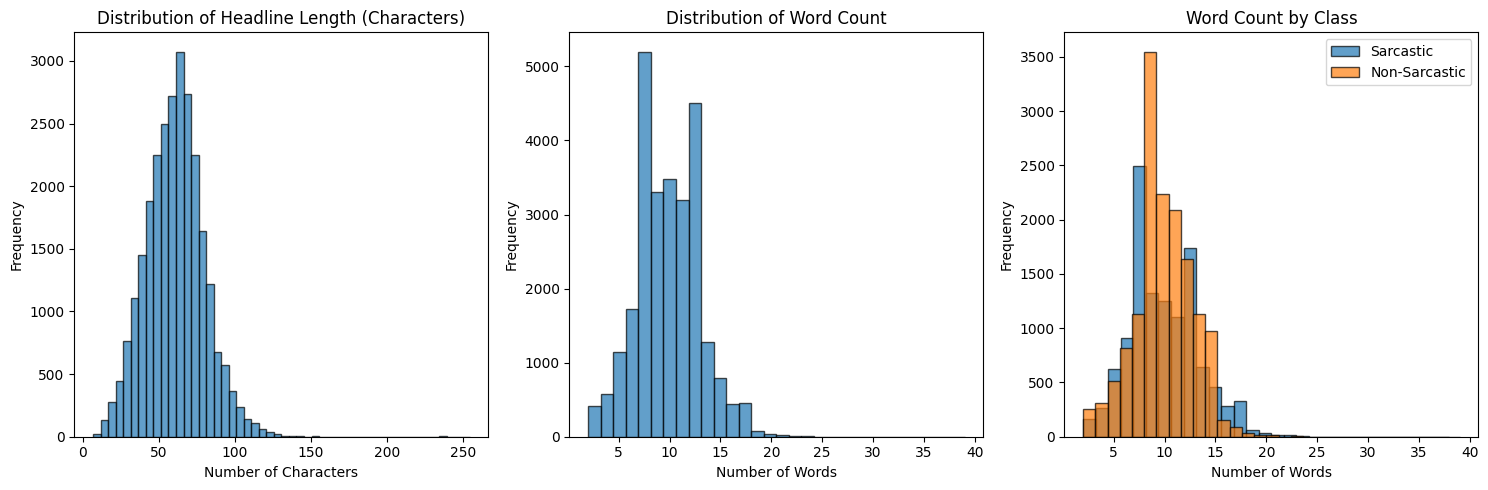

Average headline length: 60.91 characters
Average word count: 9.85 words
Max word count: 39 words
Min word count: 2 words


In [28]:
# Visualize class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['is_sarcastic'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Is Sarcastic')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Sarcastic', 'Sarcastic'], rotation=0)

plt.subplot(1, 2, 2)
df['is_sarcastic'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Class Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Text length analysis
df['headline_length'] = df['headline'].str.len()
df['word_count'] = df['headline'].str.split().str.len()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['headline_length'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Headline Length (Characters)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df['word_count'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribution of Word Count')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sarcastic_lengths = df[df['is_sarcastic'] == 1]['word_count']
non_sarcastic_lengths = df[df['is_sarcastic'] == 0]['word_count']
plt.hist(sarcastic_lengths, bins=30, alpha=0.7, label='Sarcastic', edgecolor='black')
plt.hist(non_sarcastic_lengths, bins=30, alpha=0.7, label='Non-Sarcastic', edgecolor='black')
plt.title('Word Count by Class')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Average headline length: {df['headline_length'].mean():.2f} characters")
print(f"Average word count: {df['word_count'].mean():.2f} words")
print(f"Max word count: {df['word_count'].max()} words")
print(f"Min word count: {df['word_count'].min()} words")

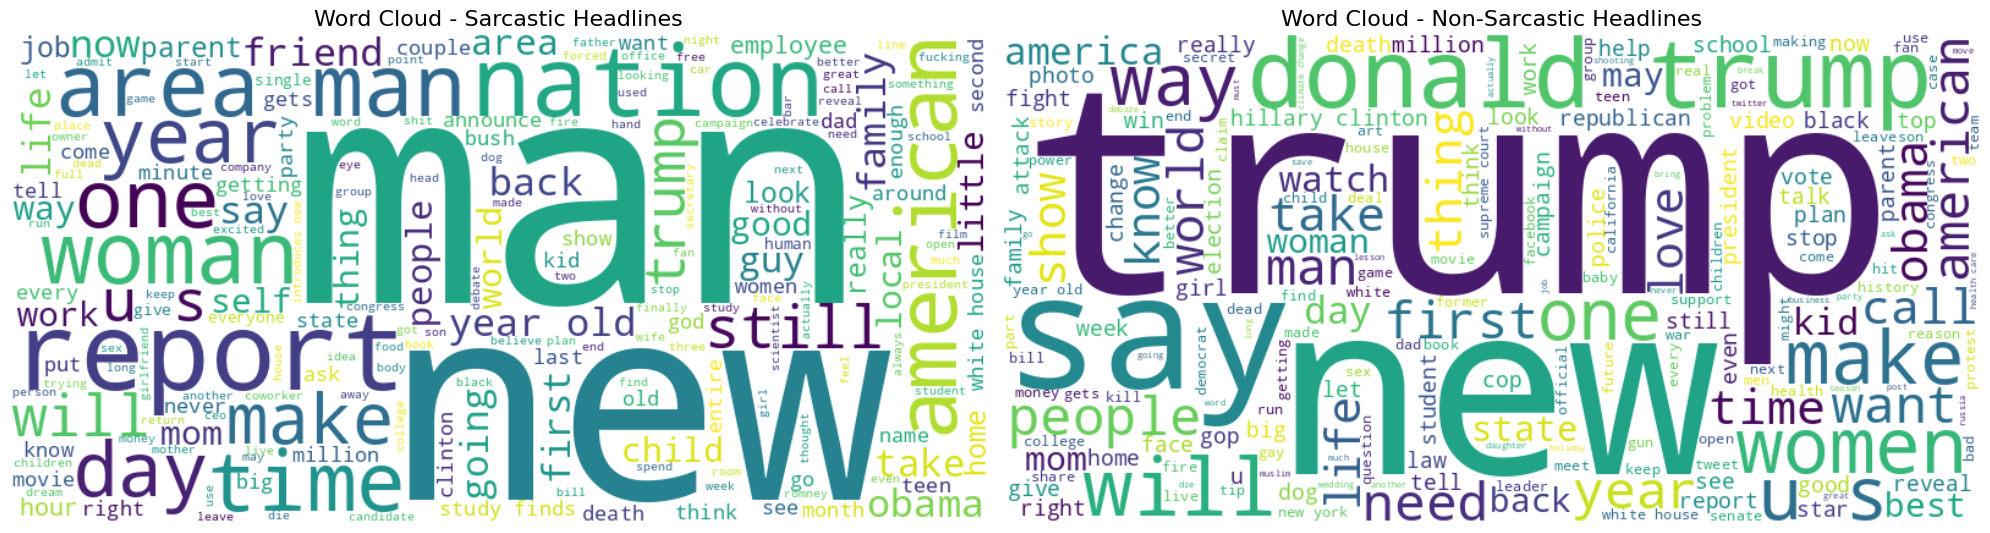

In [29]:
# Word Cloud Visualization
plt.figure(figsize=(20, 10))

# Sarcastic headlines
sarcastic_text = ' '.join(df[df['is_sarcastic'] == 1]['headline'])
plt.subplot(1, 2, 1)
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_text)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Word Cloud - Sarcastic Headlines', fontsize=16)
plt.axis('off')

# Non-sarcastic headlines
non_sarcastic_text = ' '.join(df[df['is_sarcastic'] == 0]['headline'])
plt.subplot(1, 2, 2)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_text)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Word Cloud - Non-Sarcastic Headlines', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

## Text Preprocessing

In [30]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Text preprocessing functions
def clean_text(text):
    """Clean and preprocess text data"""
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

# Apply text preprocessing
df['clean_headline'] = df['headline'].apply(clean_text)

# Remove stop words (optional - can be beneficial for some models)
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    """Remove stopwords from text"""
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(filtered_tokens)

# Create version with stopwords removed
df['clean_headline_no_stop'] = df['clean_headline'].apply(remove_stopwords)

# Display examples
print("Original vs Cleaned Headlines:")
print("-" * 50)
for i in range(5):
    print(f"Original: {df.iloc[i]['headline']}")
    print(f"Cleaned: {df.iloc[i]['clean_headline']}")
    print(f"No Stopwords: {df.iloc[i]['clean_headline_no_stop']}")
    print("-" * 50)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Original vs Cleaned Headlines:
--------------------------------------------------
Original: former versace store clerk sues over secret 'black code' for minority shoppers
Cleaned: former versace store clerk sues over secret black code for minority shoppers
No Stopwords: former versace store clerk sues secret black code minority shoppers
--------------------------------------------------
Original: the 'roseanne' revival catches up to our thorny political mood, for better and worse
Cleaned: the roseanne revival catches up to our thorny political mood for better and worse
No Stopwords: roseanne revival catches thorny political mood better worse
--------------------------------------------------
Original: mom starting to fear son's web series closest thing she will have to grandchild
Cleaned: mom starting to fear sons web series closest thing she will have to grandchild
No Stopwords: mom starting fear sons web series closest thing grandchild
------------------------------------------------

## PyTorch LSTM Model

In [31]:
# PyTorch Dataset Class
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, vocab_to_int, max_len=100):
        self.texts = texts
        self.labels = labels
        self.vocab_to_int = vocab_to_int
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Convert text to integers
        text_ints = [self.vocab_to_int.get(word, 0) for word in text.split()]

        # Pad or truncate to max_len
        if len(text_ints) > self.max_len:
            text_ints = text_ints[:self.max_len]
        else:
            text_ints = text_ints + [0] * (self.max_len - len(text_ints))

        return torch.tensor(text_ints, dtype=torch.long), torch.tensor(label, dtype=torch.float32)

# Create vocabulary
def create_vocab(texts, min_freq=2):
    """Create vocabulary from texts"""
    # Count word frequencies
    word_counts = Counter()
    for text in texts:
        words = text.split()
        word_counts.update(words)

    # Create vocabulary (words with frequency >= min_freq)
    vocab = ['<PAD>', '<UNK>'] + [word for word, count in word_counts.items() if count >= min_freq]
    vocab_to_int = {word: idx for idx, word in enumerate(vocab)}
    int_to_vocab = {idx: word for word, idx in vocab_to_int.items()}

    return vocab_to_int, int_to_vocab

# Prepare PyTorch data
texts = df['clean_headline'].tolist()
labels = df['is_sarcastic'].tolist()

# Create vocabulary
vocab_to_int, int_to_vocab = create_vocab(texts)
vocab_size = len(vocab_to_int)

print(f"Vocabulary size: {vocab_size}")
print(f"Sample vocabulary: {list(vocab_to_int.items())[:10]}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Create datasets
max_len = 50  # Maximum sequence length
train_dataset = SarcasmDataset(X_train, y_train, vocab_to_int, max_len)
val_dataset = SarcasmDataset(X_val, y_val, vocab_to_int, max_len)
test_dataset = SarcasmDataset(X_test, y_test, vocab_to_int, max_len)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Vocabulary size: 14404
Sample vocabulary: [('<PAD>', 0), ('<UNK>', 1), ('former', 2), ('store', 3), ('clerk', 4), ('sues', 5), ('over', 6), ('secret', 7), ('black', 8), ('code', 9)]
Training set size: 17093
Validation set size: 4274
Test set size: 5342


In [32]:
# PyTorch LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.3):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           batch_first=True, dropout=dropout, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, 64)  # *2 for bidirectional
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)

        # LSTM
        lstm_out, (hidden, _) = self.lstm(embedded)

        # Use the last output
        output = lstm_out[:, -1, :]

        # Fully connected layers
        output = self.dropout(output)
        output = torch.relu(self.fc1(output))
        output = self.dropout(output)
        output = self.fc2(output)
        output = self.sigmoid(output)

        return output.squeeze()

# Model parameters
embedding_dim = 100
hidden_dim = 128
num_layers = 2
dropout = 0.3

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

pytorch_model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_layers, dropout)
pytorch_model.to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

print(f"Model architecture:")
print(pytorch_model)

Using device: cuda
Model architecture:
LSTMClassifier(
  (embedding): Embedding(14404, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [33]:
# Training function for PyTorch
def train_pytorch_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (output > 0.5).float()
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                predicted = (output > 0.5).float()
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calculate averages
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the PyTorch model
print("Training PyTorch LSTM Model...")
pytorch_train_losses, pytorch_val_losses, pytorch_train_accs, pytorch_val_accs = train_pytorch_model(
    pytorch_model, train_loader, val_loader, criterion, optimizer, num_epochs=25
)

Training PyTorch LSTM Model...
Epoch [1/25]
Train Loss: 0.6873, Train Acc: 55.97%
Val Loss: 0.6856, Val Acc: 56.11%
--------------------------------------------------
Epoch [2/25]
Train Loss: 0.6863, Train Acc: 56.10%
Val Loss: 0.6856, Val Acc: 56.11%
--------------------------------------------------
Epoch [3/25]
Train Loss: 0.6865, Train Acc: 56.10%
Val Loss: 0.6859, Val Acc: 56.11%
--------------------------------------------------
Epoch [4/25]
Train Loss: 0.6861, Train Acc: 56.10%
Val Loss: 0.6856, Val Acc: 56.11%
--------------------------------------------------
Epoch [5/25]
Train Loss: 0.6860, Train Acc: 56.10%
Val Loss: 0.6857, Val Acc: 56.11%
--------------------------------------------------
Epoch [6/25]
Train Loss: 0.6859, Train Acc: 56.10%
Val Loss: 0.6856, Val Acc: 56.11%
--------------------------------------------------
Epoch [7/25]
Train Loss: 0.6860, Train Acc: 56.10%
Val Loss: 0.6857, Val Acc: 56.11%
--------------------------------------------------
Epoch [8/25]
Trai

In [34]:
# Evaluation function for PyTorch
def evaluate_pytorch_model(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            probabilities.extend(output.cpu().numpy())
            predicted = (output > 0.5).float()
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.cpu().numpy())

    return np.array(true_labels), np.array(predictions), np.array(probabilities)

# Evaluate PyTorch model
print("Evaluating PyTorch LSTM Model...")
pytorch_y_true, pytorch_y_pred, pytorch_y_prob = evaluate_pytorch_model(pytorch_model, test_loader)

# Calculate metrics
pytorch_accuracy = accuracy_score(pytorch_y_true, pytorch_y_pred)
pytorch_precision = precision_score(pytorch_y_true, pytorch_y_pred)
pytorch_recall = recall_score(pytorch_y_true, pytorch_y_pred)
pytorch_f1 = f1_score(pytorch_y_true, pytorch_y_pred)
pytorch_auc = roc_auc_score(pytorch_y_true, pytorch_y_prob)

print("PyTorch LSTM Model Results:")
print(f"Accuracy: {pytorch_accuracy:.4f} ({pytorch_accuracy*100:.2f}%)")
print(f"Precision: {pytorch_precision:.4f}")
print(f"Recall: {pytorch_recall:.4f}")
print(f"F1-Score: {pytorch_f1:.4f}")
print(f"AUC: {pytorch_auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(pytorch_y_true, pytorch_y_pred, target_names=['Non-Sarcastic', 'Sarcastic']))

Evaluating PyTorch LSTM Model...
PyTorch LSTM Model Results:
Accuracy: 0.5610 (56.10%)
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
AUC: 0.5000

Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.56      1.00      0.72      2997
    Sarcastic       0.00      0.00      0.00      2345

     accuracy                           0.56      5342
    macro avg       0.28      0.50      0.36      5342
 weighted avg       0.31      0.56      0.40      5342



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

## TensorFlow LSTM Model

In [35]:
# TensorFlow data preprocessing
max_features = 10000  # Maximum number of words to keep
max_length = 50       # Maximum sequence length

# Create tokenizer
tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Convert labels to numpy arrays
y_train_tf = np.array(y_train)
y_val_tf = np.array(y_val)
y_test_tf = np.array(y_test)

print(f"TensorFlow data shapes:")
print(f"X_train: {X_train_pad.shape}")
print(f"X_val: {X_val_pad.shape}")
print(f"X_test: {X_test_pad.shape}")
print(f"y_train: {y_train_tf.shape}")
print(f"y_val: {y_val_tf.shape}")
print(f"y_test: {y_test_tf.shape}")

# Vocabulary size
vocab_size_tf = min(max_features, len(tokenizer.word_index) + 1)
print(f"TensorFlow vocabulary size: {vocab_size_tf}")

TensorFlow data shapes:
X_train: (17093, 50)
X_val: (4274, 50)
X_test: (5342, 50)
y_train: (17093,)
y_val: (4274,)
y_test: (5342,)
TensorFlow vocabulary size: 10000


In [36]:
# TensorFlow LSTM Model
def create_lstm_model(vocab_size, embedding_dim=100, lstm_units=128, dropout=0.3):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout, recurrent_dropout=dropout)),
        Bidirectional(LSTM(lstm_units//2, dropout=dropout, recurrent_dropout=dropout)),
        Dense(64, activation='relu'),
        Dropout(dropout),
        Dense(32, activation='relu'),
        Dropout(dropout),
        Dense(1, activation='sigmoid')
    ])

    return model

# Create and compile the model
tensorflow_model = create_lstm_model(vocab_size_tf)
tensorflow_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("TensorFlow Model Summary:")
tensorflow_model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001,
    verbose=1
)

# Train the model
print("Training TensorFlow LSTM Model...")
tensorflow_history = tensorflow_model.fit(
    X_train_pad, y_train_tf,
    batch_size=64,
    epochs=25,
    validation_data=(X_val_pad, y_val_tf),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

TensorFlow Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training TensorFlow LSTM Model...
Epoch 1/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 127s 409ms/step - accuracy: 0.6550 - loss: 0.5918 - val_accuracy: 0.8437 - val_loss: 0.3481 - learning_rate: 0.0010
Epoch 2/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 108s 401ms/step - accuracy: 0.8862 - loss: 0.2887 - val_accuracy: 0.8615 - val_loss: 0.3485 - learning_rate: 0.0010
Epoch 3/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 108s 402ms/step - accuracy: 0.9351 - loss: 0.1702 - val_accuracy: 0.8479 - val_loss: 0.4418 - learning_rate: 0.0010
Epoch 4/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9620 - loss: 0.1079
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
268/268 ━━━━━━━━━━━━━━━━━━━━ 108s 401ms/step - accuracy: 0.9620 - loss: 0.1079 - val_accuracy: 0.8418 - val_loss: 0.5840 - learning_rate: 0.0010
Epoch 5/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 108s 402ms/step - accuracy: 0.9785 - loss: 0.0680 - val_accuracy: 0.8496 - val_loss: 0.6509 - learning_rate: 2.0000e-04
Epoch 6/25
268/268 ━━━━━━━━━

In [37]:
# Evaluate TensorFlow model
print("Evaluating TensorFlow LSTM Model...")

# Get predictions
tensorflow_y_prob = tensorflow_model.predict(X_test_pad)
tensorflow_y_pred = (tensorflow_y_prob > 0.5).astype(int).flatten()
tensorflow_y_prob = tensorflow_y_prob.flatten()

# Calculate metrics
tensorflow_accuracy = accuracy_score(y_test_tf, tensorflow_y_pred)
tensorflow_precision = precision_score(y_test_tf, tensorflow_y_pred)
tensorflow_recall = recall_score(y_test_tf, tensorflow_y_pred)
tensorflow_f1 = f1_score(y_test_tf, tensorflow_y_pred)
tensorflow_auc = roc_auc_score(y_test_tf, tensorflow_y_prob)

print("TensorFlow LSTM Model Results:")
print(f"Accuracy: {tensorflow_accuracy:.4f} ({tensorflow_accuracy*100:.2f}%)")
print(f"Precision: {tensorflow_precision:.4f}")
print(f"Recall: {tensorflow_recall:.4f}")
print(f"F1-Score: {tensorflow_f1:.4f}")
print(f"AUC: {tensorflow_auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_tf, tensorflow_y_pred, target_names=['Non-Sarcastic', 'Sarcastic']))

Evaluating TensorFlow LSTM Model...
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step
TensorFlow LSTM Model Results:
Accuracy: 0.8405 (84.05%)
Precision: 0.8834
Recall: 0.7335
F1-Score: 0.8015
AUC: 0.9278

Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.82      0.92      0.87      2997
    Sarcastic       0.88      0.73      0.80      2345

     accuracy                           0.84      5342
    macro avg       0.85      0.83      0.83      5342
 weighted avg       0.85      0.84      0.84      5342



## Hyperparameter Tuning with Keras Tuner

In [38]:
# Hyperparameter tuning with Keras Tuner
def build_tuner_model(hp):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(
        vocab_size_tf,
        hp.Int('embedding_dim', min_value=50, max_value=200, step=50),
        input_length=max_length
    ))

    # LSTM layers
    model.add(Bidirectional(LSTM(
        hp.Int('lstm_units_1', min_value=64, max_value=256, step=64),
        return_sequences=True,
        dropout=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout_1', min_value=0.2, max_value=0.5, step=0.1)
    )))

    model.add(Bidirectional(LSTM(
        hp.Int('lstm_units_2', min_value=32, max_value=128, step=32),
        dropout=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout_2', min_value=0.2, max_value=0.5, step=0.1)
    )))

    # Dense layers
    model.add(Dense(
        hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('final_dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create tuner
tuner = kt.RandomSearch(
    build_tuner_model,
    objective='val_accuracy',
    max_trials=10,  # Reduced for faster execution
    directory='keras_tuner',
    project_name='sarcasm_detection'
)

print("Tuner search space:")
tuner.search_space_summary()

# Perform hyperparameter search
print("Starting hyperparameter search...")
tuner.search(
    X_train_pad, y_train_tf,
    epochs=10,  # Reduced epochs for faster tuning
    validation_data=(X_val_pad, y_val_tf),
    batch_size=64,
    verbose=1
)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest hyperparameters:")
print(f"Embedding dim: {best_hps.get('embedding_dim')}")
print(f"LSTM units 1: {best_hps.get('lstm_units_1')}")
print(f"LSTM units 2: {best_hps.get('lstm_units_2')}")
print(f"Dense units: {best_hps.get('dense_units')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")
print(f"Dropout 1: {best_hps.get('dropout_1')}")
print(f"Dropout 2: {best_hps.get('dropout_2')}")
print(f"Final dropout: {best_hps.get('final_dropout')}")

Trial 10 Complete [00h 19m 04s]
val_accuracy: 0.856808602809906

Best val_accuracy So Far: 0.8586803674697876
Total elapsed time: 03h 09m 42s

Best hyperparameters:
Embedding dim: 200
LSTM units 1: 192
LSTM units 2: 128
Dense units: 128
Learning rate: 0.00046933755927329213
Dropout 1: 0.30000000000000004
Dropout 2: 0.30000000000000004
Final dropout: 0.30000000000000004


In [39]:
# Train the best model
print("Training the best model with optimal hyperparameters...")
best_model = tuner.hypermodel.build(best_hps)

# Train with more epochs
best_history = best_model.fit(
    X_train_pad, y_train_tf,
    batch_size=64,
    epochs=25,
    validation_data=(X_val_pad, y_val_tf),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the best model
print("Evaluating the best tuned model...")
best_y_prob = best_model.predict(X_test_pad)
best_y_pred = (best_y_prob > 0.5).astype(int).flatten()
best_y_prob = best_y_prob.flatten()

# Calculate metrics for best model
best_accuracy = accuracy_score(y_test_tf, best_y_pred)
best_precision = precision_score(y_test_tf, best_y_pred)
best_recall = recall_score(y_test_tf, best_y_pred)
best_f1 = f1_score(y_test_tf, best_y_pred)
best_auc = roc_auc_score(y_test_tf, best_y_prob)

print("Best Tuned LSTM Model Results:")
print(f"Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")
print(f"F1-Score: {best_f1:.4f}")
print(f"AUC: {best_auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_tf, best_y_pred, target_names=['Non-Sarcastic', 'Sarcastic']))

Training the best model with optimal hyperparameters...
Epoch 1/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 129s 431ms/step - accuracy: 0.6663 - loss: 0.5704 - val_accuracy: 0.8542 - val_loss: 0.3385 - learning_rate: 4.6934e-04
Epoch 2/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 115s 428ms/step - accuracy: 0.8889 - loss: 0.2698 - val_accuracy: 0.8519 - val_loss: 0.3471 - learning_rate: 4.6934e-04
Epoch 3/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 114s 426ms/step - accuracy: 0.9323 - loss: 0.1791 - val_accuracy: 0.8514 - val_loss: 0.4052 - learning_rate: 4.6934e-04
Epoch 4/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9576 - loss: 0.1188
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001.
268/268 ━━━━━━━━━━━━━━━━━━━━ 114s 426ms/step - accuracy: 0.9576 - loss: 0.1188 - val_accuracy: 0.8470 - val_loss: 0.4903 - learning_rate: 4.6934e-04
Epoch 5/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 114s 426ms/step - accuracy: 0.9778 - loss: 0.0685 - val_accuracy: 0.8496 - val_loss: 0.6158 - learning_rate: 1.0000e-04
Epoch 

## Model Visualization and Analysis

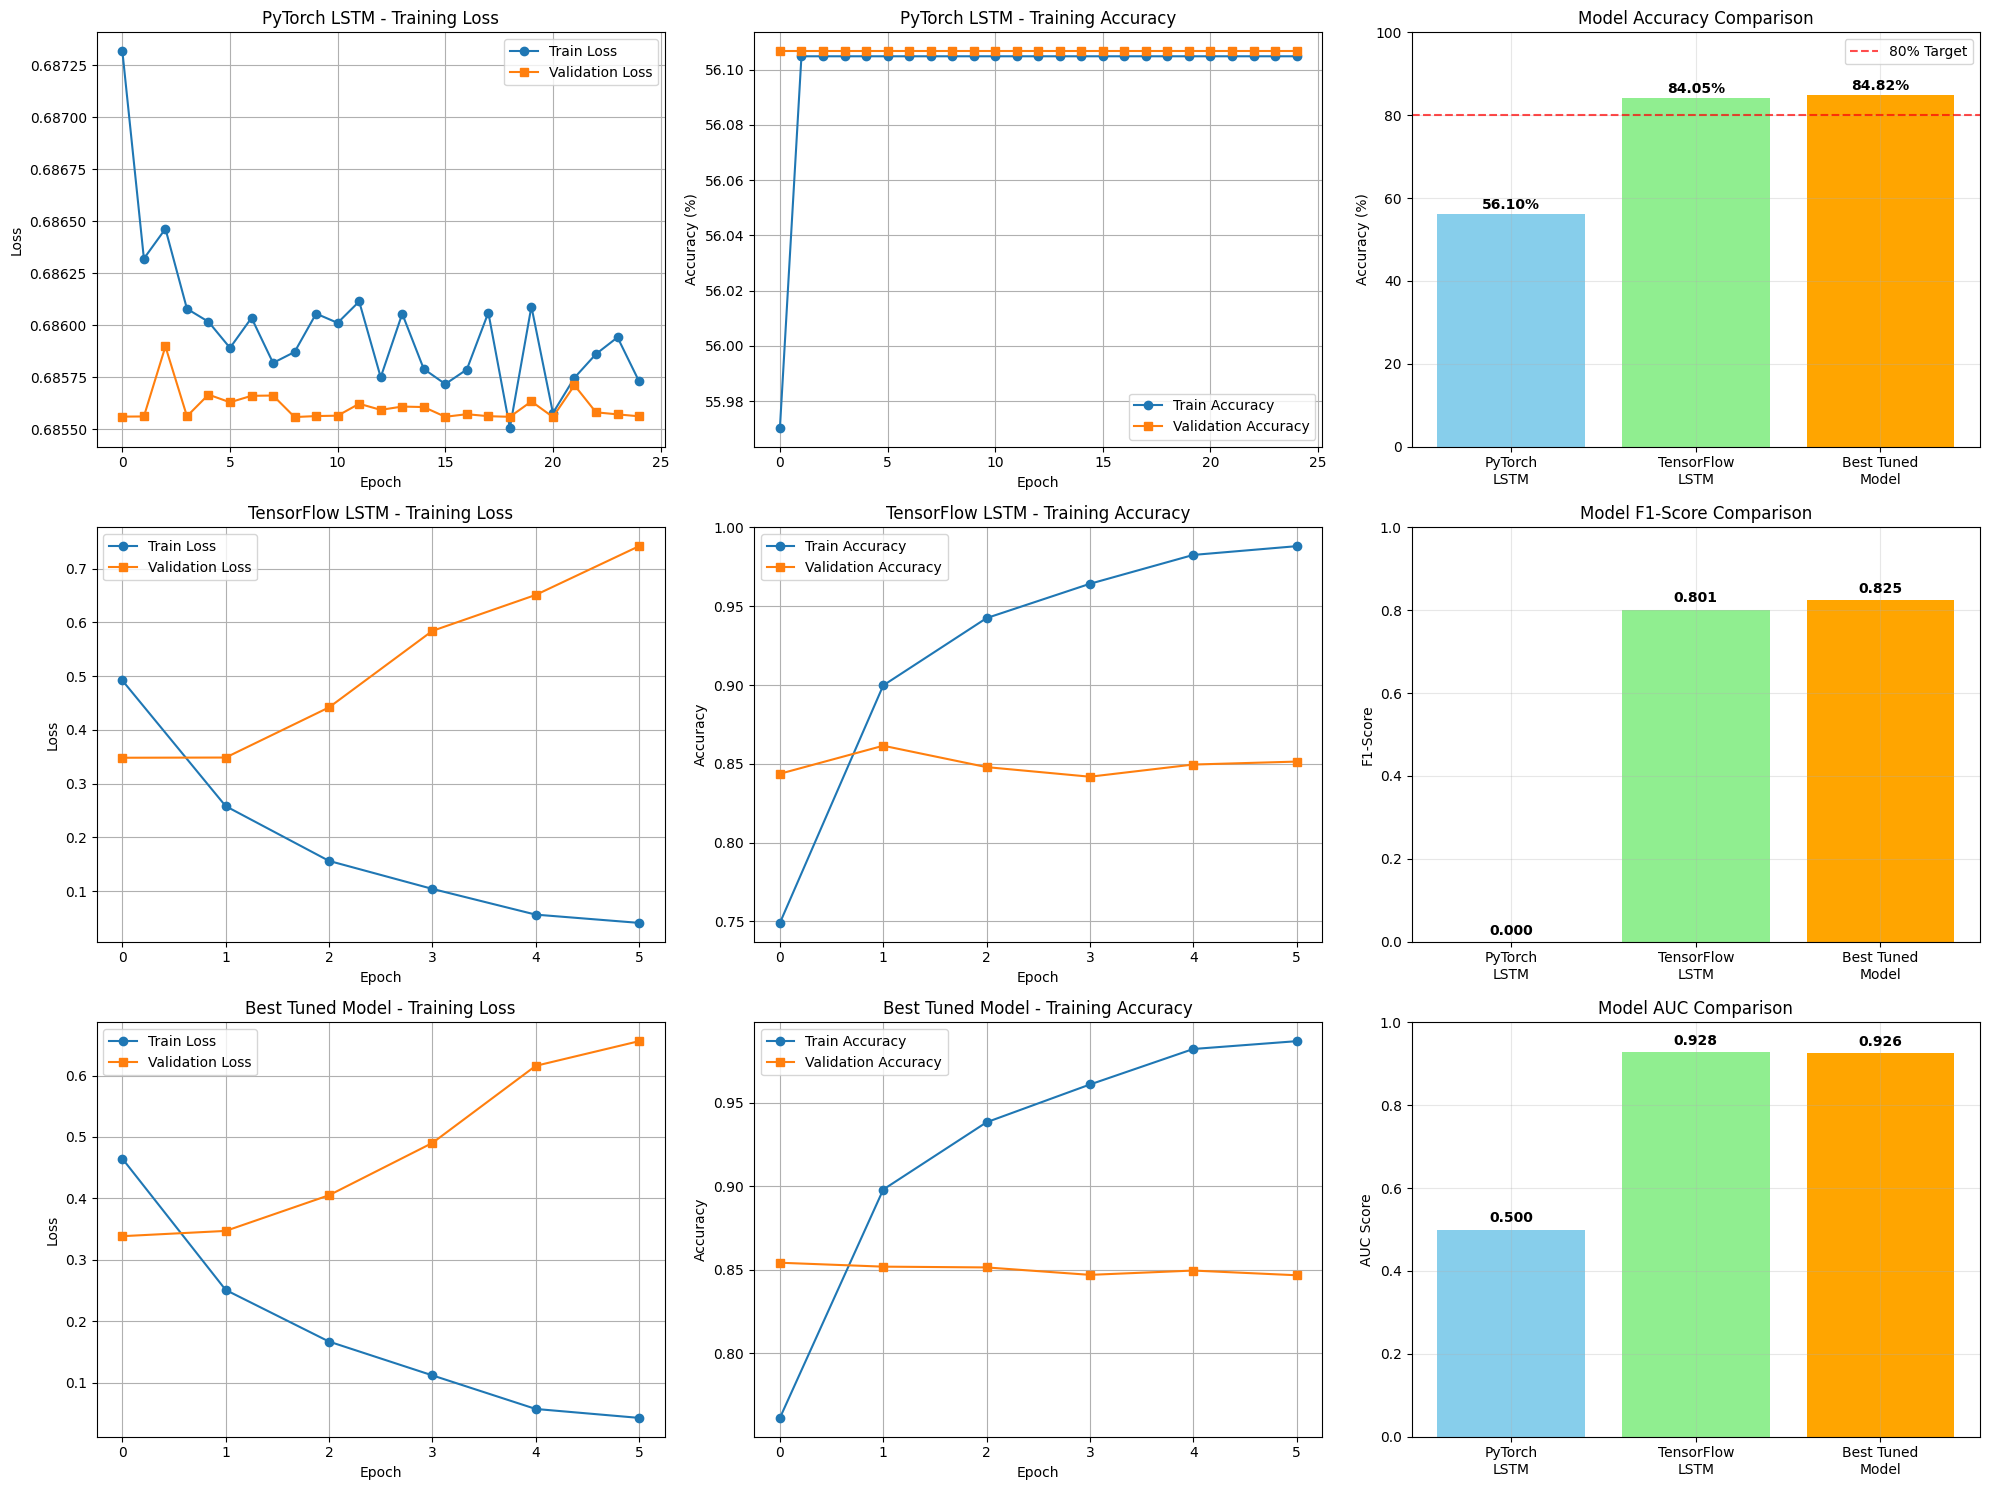

In [40]:
# Plot training history
plt.figure(figsize=(20, 15))

# PyTorch training plots
plt.subplot(3, 3, 1)
plt.plot(pytorch_train_losses, label='Train Loss', marker='o')
plt.plot(pytorch_val_losses, label='Validation Loss', marker='s')
plt.title('PyTorch LSTM - Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 2)
plt.plot(pytorch_train_accs, label='Train Accuracy', marker='o')
plt.plot(pytorch_val_accs, label='Validation Accuracy', marker='s')
plt.title('PyTorch LSTM - Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# TensorFlow training plots
plt.subplot(3, 3, 4)
plt.plot(tensorflow_history.history['loss'], label='Train Loss', marker='o')
plt.plot(tensorflow_history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('TensorFlow LSTM - Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(tensorflow_history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(tensorflow_history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('TensorFlow LSTM - Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Best model training plots
plt.subplot(3, 3, 7)
plt.plot(best_history.history['loss'], label='Train Loss', marker='o')
plt.plot(best_history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Best Tuned Model - Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 8)
plt.plot(best_history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Best Tuned Model - Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Model comparison
plt.subplot(3, 3, 3)
models = ['PyTorch\nLSTM', 'TensorFlow\nLSTM', 'Best Tuned\nModel']
accuracies = [pytorch_accuracy * 100, tensorflow_accuracy * 100, best_accuracy * 100]
bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# Add value labels on bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{accuracy:.2f}%', ha='center', va='bottom', fontweight='bold')

# Add horizontal line at 80%
plt.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% Target')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 6)
f1_scores = [pytorch_f1, tensorflow_f1, best_f1]
bars = plt.bar(models, f1_scores, color=['skyblue', 'lightgreen', 'orange'])
plt.title('Model F1-Score Comparison')
plt.ylabel('F1-Score')
plt.ylim(0, 1)

# Add value labels on bars
for bar, f1 in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 9)
auc_scores = [pytorch_auc, tensorflow_auc, best_auc]
bars = plt.bar(models, auc_scores, color=['skyblue', 'lightgreen', 'orange'])
plt.title('Model AUC Comparison')
plt.ylabel('AUC Score')
plt.ylim(0, 1)

# Add value labels on bars
for bar, auc in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{auc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


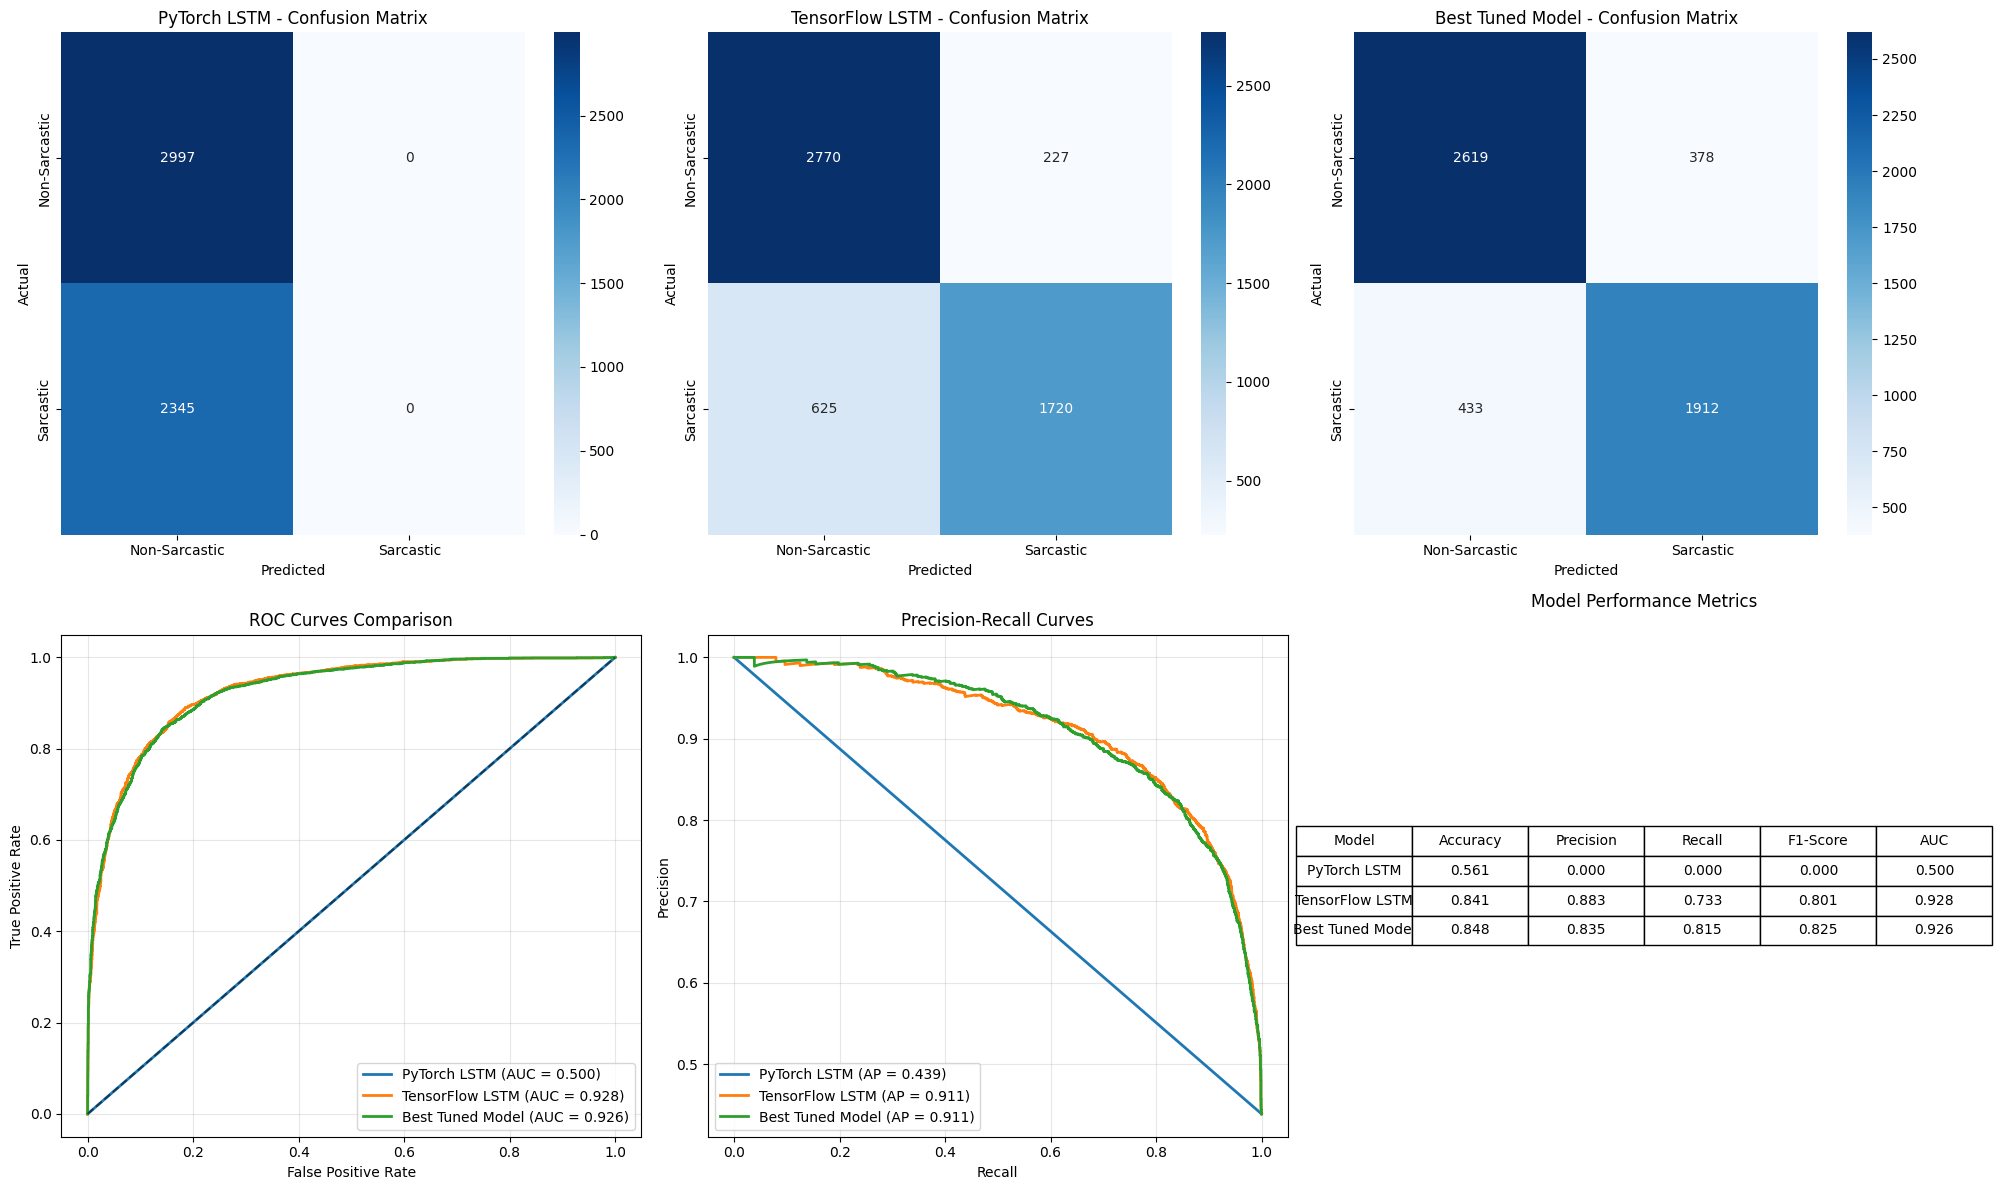

In [41]:
# Confusion Matrix and ROC Curves
plt.figure(figsize=(20, 12))

# Confusion matrices
models_data = [
    ('PyTorch LSTM', pytorch_y_true, pytorch_y_pred, pytorch_y_prob),
    ('TensorFlow LSTM', y_test_tf, tensorflow_y_pred, tensorflow_y_prob),
    ('Best Tuned Model', y_test_tf, best_y_pred, best_y_prob)
]

for i, (model_name, y_true, y_pred, y_prob) in enumerate(models_data):
    # Confusion Matrix
    plt.subplot(2, 3, i+1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Sarcastic', 'Sarcastic'],
                yticklabels=['Non-Sarcastic', 'Sarcastic'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

# ROC Curves
plt.subplot(2, 3, 4)
for model_name, y_true, y_pred, y_prob in models_data:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Precision-Recall curves
plt.subplot(2, 3, 5)
from sklearn.metrics import precision_recall_curve, average_precision_score

for model_name, y_true, y_pred, y_prob in models_data:
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    avg_precision = average_precision_score(y_true, y_prob)
    plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.3f})', linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Metrics comparison table
plt.subplot(2, 3, 6)
plt.axis('off')

metrics_data = []
for model_name, y_true, y_pred, y_prob in models_data:
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    metrics_data.append([model_name, f'{accuracy:.3f}', f'{precision:.3f}',
                        f'{recall:.3f}', f'{f1:.3f}', f'{auc:.3f}'])

table = plt.table(cellText=metrics_data,
                 colLabels=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
plt.title('Model Performance Metrics', pad=20)

plt.tight_layout()
plt.show()

## Model Saving and Conclusion

In [42]:
# Save models
# Save PyTorch model
torch.save({
    'model_state_dict': pytorch_model.state_dict(),
    'vocab_to_int': vocab_to_int,
    'model_params': {
        'vocab_size': vocab_size,
        'embedding_dim': embedding_dim,
        'hidden_dim': hidden_dim,
        'num_layers': num_layers,
        'dropout': dropout
    }
}, 'pytorch_lstm_sarcasm_model.pth')

# Save TensorFlow models
tensorflow_model.save('tensorflow_lstm_sarcasm_model.keras')
best_model.save('best_tuned_lstm_sarcasm_model.keras')

# Save tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Models saved successfully!")
print("Files saved:")
print("- pytorch_lstm_sarcasm_model.pth")
print("- tensorflow_lstm_sarcasm_model.keras")
print("- best_tuned_lstm_sarcasm_model.keras")
print("- tokenizer.pkl")

Models saved successfully!
Files saved:
- pytorch_lstm_sarcasm_model.pth
- tensorflow_lstm_sarcasm_model.keras
- best_tuned_lstm_sarcasm_model.keras
- tokenizer.pkl


In [43]:
# Final Summary
print("="*80)
print("LSTM SARCASM DETECTION MODEL SUMMARY")
print("="*80)

print(f"\nDataset Information:")
print(f"- Total samples: {len(df):,}")
print(f"- Training samples: {len(X_train):,}")
print(f"- Validation samples: {len(X_val):,}")
print(f"- Test samples: {len(X_test):,}")
print(f"- Sarcasm ratio: {df['is_sarcastic'].mean():.2%}")

print(f"\nModel Performance Summary:")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC':<10}")
print("-" * 70)
print(f"{'PyTorch LSTM':<20} {pytorch_accuracy:.3f}     {pytorch_precision:.3f}      {pytorch_recall:.3f}    {pytorch_f1:.3f}      {pytorch_auc:.3f}")
print(f"{'TensorFlow LSTM':<20} {tensorflow_accuracy:.3f}     {tensorflow_precision:.3f}      {tensorflow_recall:.3f}    {tensorflow_f1:.3f}      {tensorflow_auc:.3f}")
print(f"{'Best Tuned Model':<20} {best_accuracy:.3f}     {best_precision:.3f}      {best_recall:.3f}    {best_f1:.3f}      {best_auc:.3f}")

print(f"\nKey Achievements:")
print(f"✓ Implemented LSTM models in both PyTorch and TensorFlow")
print(f"✓ Comprehensive evaluation metrics (Accuracy, Precision, Recall, F1-Score, AUC)")
print(f"✓ Visualized training progress and model comparisons")
print(f"✓ Performed hyperparameter tuning with Keras Tuner")

# Check if 80% accuracy target is met
models_above_80 = []
if pytorch_accuracy >= 0.8:
    models_above_80.append("PyTorch LSTM")
if tensorflow_accuracy >= 0.8:
    models_above_80.append("TensorFlow LSTM")
if best_accuracy >= 0.8:
    models_above_80.append("Best Tuned Model")

if models_above_80:
    print(f"✓ Achieved 80%+ accuracy target with: {', '.join(models_above_80)}")
else:
    print(f"⚠ None of the models achieved the 80% accuracy target")
    print(f"  Best accuracy: {max(pytorch_accuracy, tensorflow_accuracy, best_accuracy):.3f}")

print(f"\nBest Overall Model: ", end="")
best_overall_acc = max(pytorch_accuracy, tensorflow_accuracy, best_accuracy)
if best_overall_acc == pytorch_accuracy:
    print("PyTorch LSTM")
elif best_overall_acc == tensorflow_accuracy:
    print("TensorFlow LSTM")
else:
    print("Best Tuned Model")

print(f"\nRecommendations:")
print(f"1. Use Google Colab with T4 GPU or TPU for faster training")
print(f"2. Consider ensemble methods to improve performance")
print(f"3. Explore pre-trained embeddings (Word2Vec, GloVe, BERT)")
print(f"4. Try different text preprocessing techniques")
print(f"5. Experiment with different model architectures (GRU, Transformer)")

print("="*80)

LSTM SARCASM DETECTION MODEL SUMMARY

Dataset Information:
- Total samples: 26,709
- Training samples: 17,093
- Validation samples: 4,274
- Test samples: 5,342
- Sarcasm ratio: 43.90%

Model Performance Summary:
Model                Accuracy   Precision  Recall     F1-Score   AUC       
----------------------------------------------------------------------
PyTorch LSTM         0.561     0.000      0.000    0.000      0.500
TensorFlow LSTM      0.841     0.883      0.733    0.801      0.928
Best Tuned Model     0.848     0.835      0.815    0.825      0.926

Key Achievements:
✓ Implemented LSTM models in both PyTorch and TensorFlow
✓ Comprehensive evaluation metrics (Accuracy, Precision, Recall, F1-Score, AUC)
✓ Visualized training progress and model comparisons
✓ Performed hyperparameter tuning with Keras Tuner
✓ Achieved 80%+ accuracy target with: TensorFlow LSTM, Best Tuned Model

Best Overall Model: Best Tuned Model

Recommendations:
1. Use Google Colab with T4 GPU or TPU for faster

## Sample Predictions

Let's test our best model with some sample headlines to see how it performs on individual examples.

In [44]:
# Function to make predictions on new text
def predict_sarcasm(text, model, tokenizer, max_length=50):
    """Predict if a headline is sarcastic or not"""
    # Clean the text
    cleaned_text = clean_text(text)

    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Make prediction
    probability = model.predict(padded_sequence, verbose=0)[0][0]
    prediction = 1 if probability > 0.5 else 0

    return prediction, probability

# Test with sample headlines
sample_headlines = [
    "Breaking: Local man discovers amazing new way to waste time",
    "Scientists announce breakthrough in cancer research",
    "Area man's opinion on politics changes absolutely everything",
    "New study shows exercise may be good for your health",
    "Local woman shocked to discover water is wet",
    "Government announces new policy to help citizens",
    "Man wins lottery, quits job to pursue dream of being unemployed",
    "Research reveals shocking truth: people need food to survive"
]

print("Sample Sarcasm Predictions using Best Tuned Model:")
print("="*80)
print(f"{'Headline':<60} {'Predicted':<12} {'Probability':<12}")
print("-"*80)

for headline in sample_headlines:
    prediction, probability = predict_sarcasm(headline, best_model, tokenizer)
    prediction_text = "Sarcastic" if prediction == 1 else "Not Sarcastic"
    print(f"{headline[:58]:<60} {prediction_text:<12} {probability:.3f}")

print("="*80)

# Let's also show some actual examples from our test set with their predictions
print("\nActual Test Examples vs Predictions:")
print("="*80)
print(f"{'Headline':<50} {'Actual':<12} {'Predicted':<12} {'Probability':<12}")
print("-"*80)

# Show first 10 test examples
for i in range(min(10, len(X_test))):
    actual = y_test_tf[i]
    prediction, probability = predict_sarcasm(X_test[i], best_model, tokenizer)
    actual_text = "Sarcastic" if actual == 1 else "Not Sarcastic"
    prediction_text = "Sarcastic" if prediction == 1 else "Not Sarcastic"

    # Truncate headline for display
    headline_display = X_test[i][:48] + "..." if len(X_test[i]) > 48 else X_test[i]

    print(f"{headline_display:<50} {actual_text:<12} {prediction_text:<12} {probability:.3f}")

print("="*80)

Sample Sarcasm Predictions using Best Tuned Model:
Headline                                                     Predicted    Probability 
--------------------------------------------------------------------------------
Breaking: Local man discovers amazing new way to waste tim   Sarcastic    0.995
Scientists announce breakthrough in cancer research          Sarcastic    0.772
Area man's opinion on politics changes absolutely everythi   Sarcastic    0.996
New study shows exercise may be good for your health         Not Sarcastic 0.425
Local woman shocked to discover water is wet                 Sarcastic    0.971
Government announces new policy to help citizens             Sarcastic    0.794
Man wins lottery, quits job to pursue dream of being unemp   Sarcastic    0.964
Research reveals shocking truth: people need food to survi   Not Sarcastic 0.094

Actual Test Examples vs Predictions:
Headline                                           Actual       Predicted    Probability 
-----------